In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load integrated dataset
df = pd.read_csv("../data/processed/integrated_dataset.csv", index_col=0)

# Split features and target
X = df.drop(columns=['outcome'], errors='ignore')
y = df['outcome'] if 'outcome' in df.columns else pd.Series([np.nan] * len(df), index=df.index)

# Encode 'sex' column if present
if 'sex' in X.columns:
    X['sex'] = X['sex'].map({'M': 0, 'F': 1})

# Drop empty columns
X = X.dropna(axis=1, how='all')

# Impute missing values with column means
X = X.fillna(X.mean(numeric_only=True))

# Handle missing or undefined target values
if y.isna().sum() > 0 or y.nunique() < 2:
    print("Missing or undefined 'outcome'. Generating random labels...")
    np.random.seed(42)
    y = np.random.choice(['Healthy', 'Diseased'], size=len(X))
    y = pd.Series(y, index=X.index)

# Remove samples with missing target values
X = X[~y.isna()]
y = y[~y.isna()]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [2]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models to evaluate
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Evaluate each model using macro-averaged F1 score
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1_macro')
    print(f"{name} - F1 macro: {scores.mean():.3f} ± {scores.std():.3f}")


Random Forest - F1 macro: 0.544 ± 0.121
Logistic Regression - F1 macro: 0.553 ± 0.061


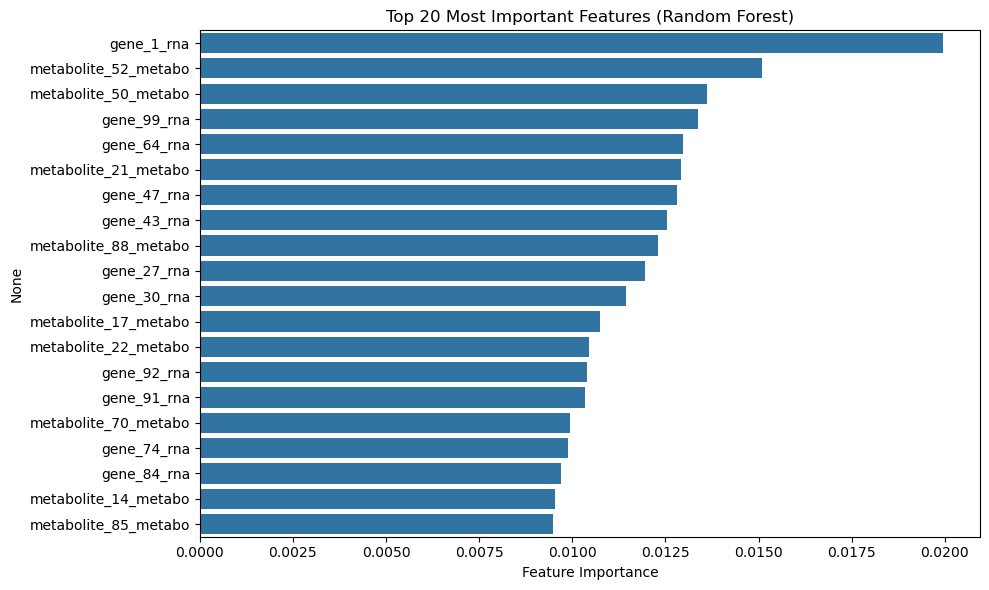

In [4]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

# Compute and display top feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 20 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()
